# 1/ Import libraries

In [2]:
import pandas as pd
import pandas._typing
import numpy as np
import mlflow
import seaborn as sns
import xgboost as xgb
import optuna
import warnings
warnings.simplefilter('ignore')
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from typing import cast
from sklearn.exceptions import NotFittedError
from sklearn.utils.validation import check_is_fitted
from IPython.display import display
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

C:\Users\lucil\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2/ Dataset Exploration

In [3]:
# Load the datasets
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

In [4]:
train0 = train.drop("loan_status", axis=1)
train0

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [5]:
# Combine the test and train datasets for consistent preprocessing
both = pd.concat([test, train0], axis=0)
both.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [6]:
# Function to filter out individuals older than 65
def remove_age(both):
    return both[both['person_age'] <= 65]

# Remove individuals older than 65 years from the dataset
combine = remove_age(both)

# Display the cleaned dataset
combine

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [7]:
# Display information about the dataset
combine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97680 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          97680 non-null  int64  
 1   person_age                  97680 non-null  int64  
 2   person_income               97680 non-null  int64  
 3   person_home_ownership       97680 non-null  object 
 4   person_emp_length           97680 non-null  float64
 5   loan_intent                 97680 non-null  object 
 6   loan_grade                  97680 non-null  object 
 7   loan_amnt                   97680 non-null  int64  
 8   loan_int_rate               97680 non-null  float64
 9   loan_percent_income         97680 non-null  float64
 10  cb_person_default_on_file   97680 non-null  object 
 11  cb_person_cred_hist_length  97680 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.7+ MB


In [8]:
combine.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,97680.000000,97680.000000,9.768000e+04,97680.000000,97680.000000,97680.000000,97680.000000,97680.000000
mean,48871.521775,27.529187,6.405041e+04,4.695925,9231.028378,10.670607,0.159369,5.809081
std,28215.160668,5.929158,3.793658e+04,3.921770,5568.423730,3.028462,0.091663,4.021972
min,0.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,24438.750000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,48872.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,73304.250000,30.000000,7.568900e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,65.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [9]:
combine.dropna()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


# a) Data Cleaning

In [10]:
# Fill missing values in numerical columns with the column mean
filled = combine.fillna(combine.mean(numeric_only=True))
filled

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [11]:
# Remove duplicates in the dataset
no_duplicates = filled.drop_duplicates()
no_duplicates

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


# b) Export the combine dataset

In [12]:
# Exporter le DataFrame vers un fichier xlsx
no_duplicates.to_excel('All_data.xlsx', index=False)

# C) Plotting variables

In [13]:
df = pd.read_excel("All_data.xlsx")

Text(0.5, 1.0, 'Distribution of Loan Amount')

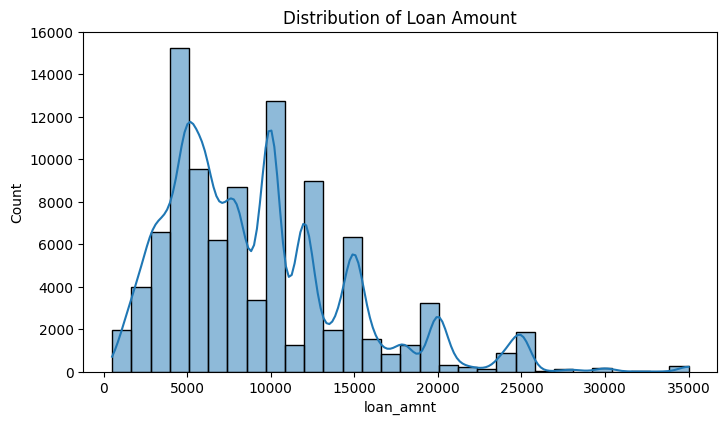

In [14]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Distribution of the target variable (loan_amnt)
plt.subplot(3, 2, 1)
sns.histplot(df['loan_amnt'], kde=True, bins=30)
plt.title('Distribution of Loan Amount')

Text(0.5, 1.0, 'Distribution of Applicant Age')

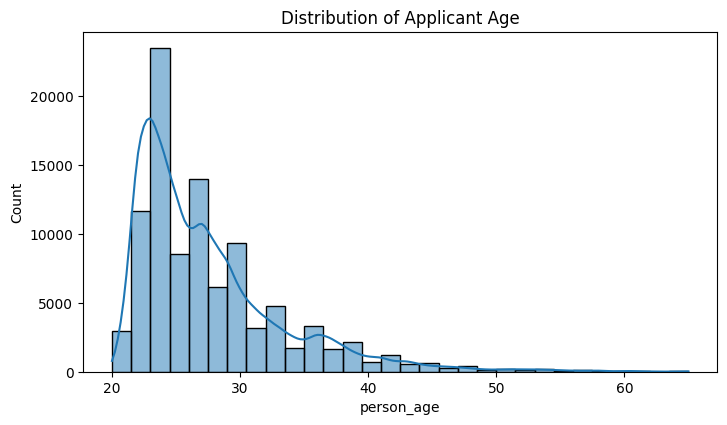

In [15]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Age distribution
plt.subplot(3, 2, 2)
sns.histplot(df['person_age'], kde=True, bins=30)
plt.title('Distribution of Applicant Age')

Text(0.5, 1.0, 'Distribution of Applicant Income')

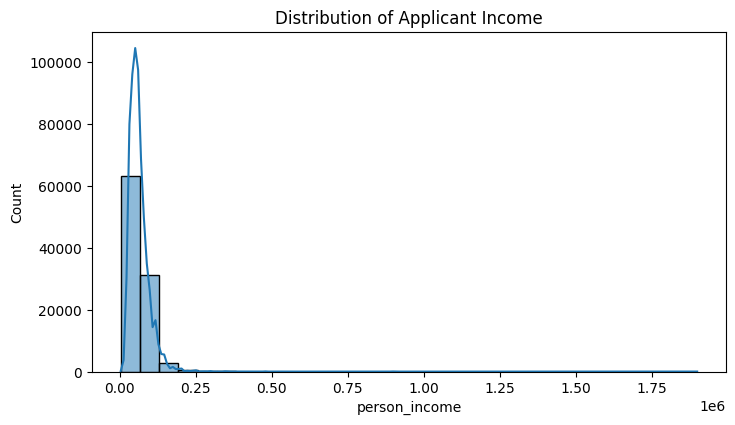

In [16]:
plt.figure(figsize=(18, 15))

# Income distribution
plt.subplot(3, 2, 3)
sns.histplot(df['person_income'], kde=True, bins=30)
plt.title('Distribution of Applicant Income')

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'HOMEIMPROVEMENT'),
  Text(1, 0, 'PERSONAL'),
  Text(2, 0, 'VENTURE'),
  Text(3, 0, 'DEBTCONSOLIDATION'),
  Text(4, 0, 'EDUCATION'),
  Text(5, 0, 'MEDICAL')])

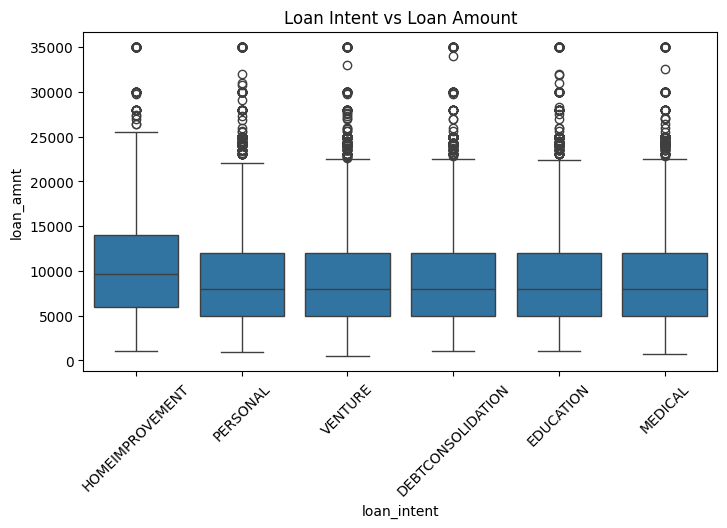

In [17]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Loan intent vs. Loan amount
plt.subplot(3, 2, 4)
sns.boxplot(x='loan_intent', y='loan_amnt', data=df)
plt.title('Loan Intent vs Loan Amount')
plt.xticks(rotation=45)

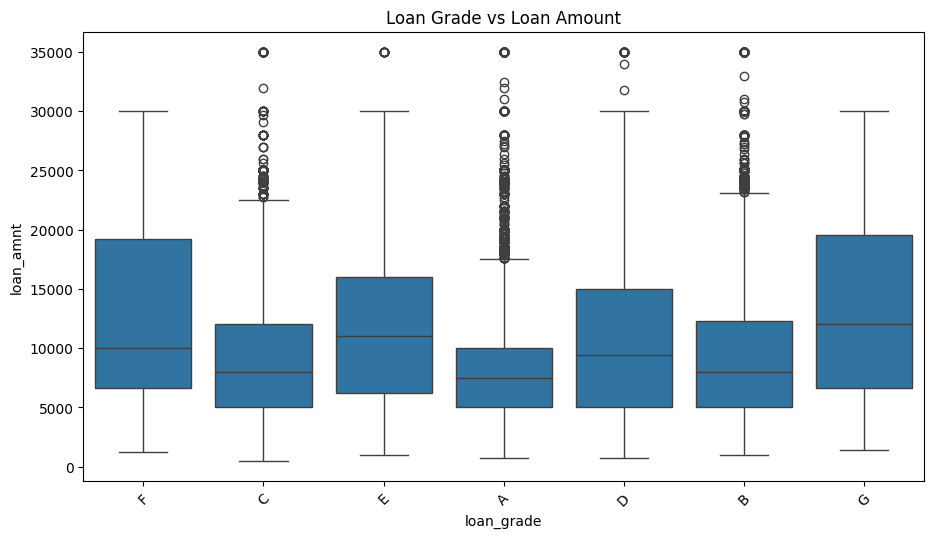

In [18]:
# Set up the plotting environment
plt.figure(figsize=(18, 15))

# Loan grade vs. Loan amount
plt.subplot(3, 2, 5)
sns.boxplot(x='loan_grade', y='loan_amnt', data=df)
plt.title('Loan Grade vs Loan Amount')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# d) Conversion of categorical variables and correlation matrix

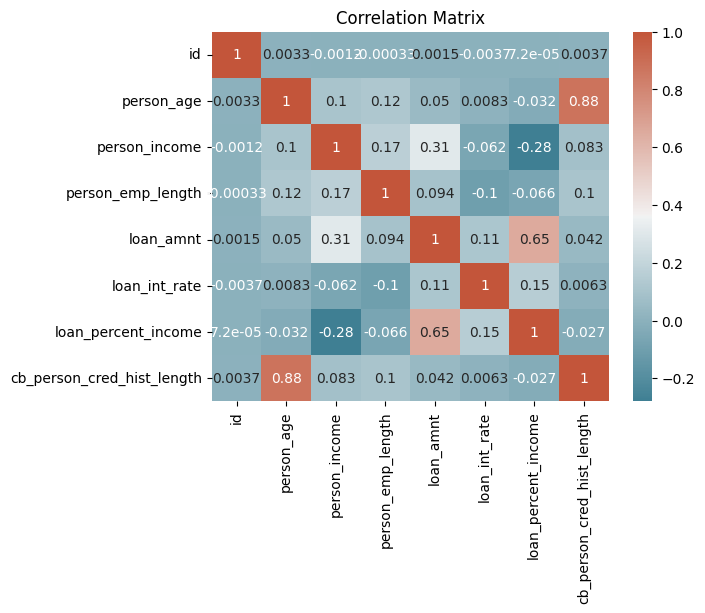

In [19]:
# Generate a correlation matrix for numerical features
Change = df.select_dtypes(include=['number'])
correlation = Change.corr()
sns.heatmap(correlation, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title("Correlation Matrix")
plt.show()